In [1]:
import os
os.chdir("./src")
print(os.getcwd())

/home/qudgks/workspace/NCLAD-tset/CLAD-master/src


In [2]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import config
import pdb
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.model_selection import train_test_split
col = ["red","green","blue","yellow","pink","orange","purple","brown","cyan","magenta",
   "lightblue","aqua",'tan','indigo','lime','tomato','maroon','gold','chartreuse','khaki']

cuda


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import time
import os
import pdb

def apply_odin(net, train_x,test_in, test_out,center,test_in_emb = None,test_out_emb= None):


    print("in-distribution data")

    train_x_loader = DataLoader(train_x, batch_size=1, shuffle=False)
    test_in_loader = DataLoader(test_in, batch_size=1, shuffle=False)
    test_out_loader = DataLoader(test_out, batch_size=1, shuffle=False)   
    
    
    test_num = max(len(test_in), len(test_out))
    score_ = []
    criterion = nn.CrossEntropyLoss()
    t0 = time.time()
    if os.path.exists(config.sf_scores_path) == False:
        os.makedirs(config.sf_scores_path)
    f1 = open(config.base_in_path, "w")
    f2 = open(config.base_out_path, "w")
    g1 = open(config.odin_in_path, "w")
    g2 = open(config.odin_out_path, "w")

    temper = 1
    noise_magnitude = 0.001
    cls_emb = []
    train_hid_emb = []
    indist_hid_emb = []
    ood_hid_emb = []
    lab = []
    for j, data in enumerate(train_x_loader):
        inputs = Variable(data.float().cuda(config.device),requires_grad=True)     
        net.eval()
        outputs, hidden_dim = net(inputs)
        train_hid_emb.append(hidden_dim)
    #in-dist
    for j, data in enumerate(test_in_loader):
      
        inputs = Variable(data.float().cuda(config.device),requires_grad=True)     
        net.eval()
        outputs, hidden_dim = net(inputs)
        indist_hid_emb.append(hidden_dim)
        
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()

        nnOutputs = nnOutputs.reshape(1, -1)
        nnOutputs = nnOutputs - np.max(nnOutputs)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            
        f1.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))
        score_.append(np.max(nnOutputs))      
        outputs = outputs / temper
    
        maxIndexTemp = np.argmax(nnOutputs)

        lab.append(maxIndexTemp)
        
        labels = Variable(torch.LongTensor([maxIndexTemp]).cuda(config.device))
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = torch.ge(inputs.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        gradient = gradient * 50 / (79.0 / 255.0)
        
        tempInputs = torch.add(inputs.data, -noise_magnitude, gradient)
        outputs, _  = net(Variable(tempInputs))
        outputs = outputs / temper
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        
        nnOutputs = nnOutputs.reshape(-1)
        nnOutputs = nnOutputs - np.max(nnOutputs)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            
            
        g1.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))

        if j % 100 == 99:
            print("{:4}/{:4} data processed, {:.1f} seconds used.".format(
                j + 1,
                #  test_num,
                len(test_in_loader),
                time.time() - t0))
            t0 = time.time()

        if j > test_num:
            break

        torch.cuda.empty_cache()


    print("out-of-distribution data")

    normal_cls = len(cls_emb)

    for j, data in enumerate(test_out_loader):
        
        inputs = Variable(data.cuda(config.device), requires_grad=True) #오딘은 무조건 숫자여야함        
        net.eval()
        outputs, hidden_dim = net(inputs)       
        ood_hid_emb.append(hidden_dim)
        
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        nnOutputs = nnOutputs.reshape(1,-1)#*distence.reshape(1,-1)
        nnOutputs = nnOutputs - np.max(nnOutputs)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            
        

        f2.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))

        score_.append(np.max(nnOutputs))      
        outputs = outputs / temper

        maxIndexTemp = np.argmax(nnOutputs)
        lab.append(maxIndexTemp)
        labels = Variable(torch.LongTensor([maxIndexTemp]).cuda(config.device))
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(inputs.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        gradient = gradient * 50 / (79.0 / 255.0)

        tempInputs = torch.add(inputs.data, -noise_magnitude, gradient)
        outputs, _ = net(Variable(tempInputs))
        outputs = outputs / temper
            
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        
        nnOutputs = nnOutputs.reshape(-1)#*distence.reshape(-1)
        nnOutputs = nnOutputs - np.max(nnOutputs)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            
            
        g2.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))

        if j % 100 == 99:
            print("{:4}/{:4} data processed, {:.1f} seconds used.".format(
                j + 1,
                #  test_num,
                len(test_out_loader),
                time.time() - t0))
            t0 = time.time()

        if j > test_num:
            break

        torch.cuda.empty_cache()


    emb=torch.cat((test_in,test_out)).numpy() #이 부분 수정
    embed = pd.DataFrame(emb,columns=['emb_x',"emb_y"])
    normal_ = ["normal" for i in range(test_in.shape[0])]
    abnormal_ = ["abnormal" for i in range(test_out.shape[0])]
    normal_.extend(abnormal_)
    pred_cls = [i for i in lab]
    embed["pred_cls"]=pred_cls
    embed['score'] = score_
    embed['label_gt'] = normal_
    train_hid_emb = torch.cat(train_hid_emb)
    indist_hid_emb = torch.cat(indist_hid_emb)
    ood_hid_emb = torch.cat(ood_hid_emb)
    return embed, train_hid_emb.detach().cpu().numpy(), indist_hid_emb.detach().cpu().numpy(),ood_hid_emb.detach().cpu().numpy()


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import config

import pdb
import pandas as pd

def tpr95():
    # calculate the falsepositive error when tpr is 95%

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    start = 0.1
    end = 1
    gap = (end - start) / 100000
    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            #  if tpr <= 0.955 and tpr >= 0.945:
            fpr += error2
            total += 1
    fprBase = fpr / total

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)

    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 > delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            #  if tpr <= 0.955 and tpr >= 0.945:
            fpr += error2
            total += 1
    fprOdin = fpr / total

    return fprBase, fprOdin


def f1():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    precision, recall, thresholds = precision_recall_curve(labels,
                                                           scores,
                                                           pos_label=0)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1Base = max(f1)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    precision, recall, thresholds = precision_recall_curve(labels,
                                                           scores,
                                                           pos_label=0)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1Odin = max(f1)

    return f1Base, f1Odin



def auroc():
    # calculate the AUROC
    # TODO: adjust the length with test len

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    
    np.save(os.path.join(config.sub_log_path, "labels_base.txt"), labels)
    np.save(os.path.join(config.sub_log_path, "scores_base.txt"), scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
    ix = np.argmax(tpr-fpr)
    TH = thresholds[ix]
    aurocBase = auc(fpr, tpr)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    
    np.save(os.path.join(config.sub_log_path, "labels_odin.txt"), labels)
    np.save(os.path.join(config.sub_log_path, "scores_odin.txt"), scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
    aurocOdin = auc(fpr, tpr)
    #if aurocOdin < 0.5: aurocOdin = 1-aurocOdin

    return aurocBase, aurocOdin, TH


def auprIn():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    precisionVec = []
    recallVec = []
    auprBase = 0.0
    recallTemp = 1.0
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fp = np.sum(np.sum(Y1 >= delta)) / np.float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        precisionVec.append(precision)
        recallVec.append(recall)
        auprBase += (recallTemp - recall) * precision
        recallTemp = recall
    auprBase += recall * precision

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    auprOdin = 0.0
    recallTemp = 1.0
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fp = np.sum(np.sum(Y1 >= delta)) / np.float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        auprOdin += (recallTemp - recall) * precision
        recallTemp = recall
    auprOdin += recall * precision
    return auprBase, auprOdin


def auprOut():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    auprBase = 0.0
    recallTemp = 1.0
    for delta in np.arange(end, start, -gap):
        fp = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        tp = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
        if tp + fp == 0: break
        precision = tp / (tp + fp)
        recall = tp
        auprBase += (recallTemp - recall) * precision
        recallTemp = recall
    auprBase += recall * precision

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    auprOdin = 0.0
    recallTemp = 1.0
    for delta in np.arange(end, start, -gap):
        fp = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        tp = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
        if tp + fp == 0: break
        precision = tp / (tp + fp)
        recall = tp
        auprOdin += (recallTemp - recall) * precision
        recallTemp = recall
    auprOdin += recall * precision
    return auprBase, auprOdin


def detection():
    # calculate the minimum detection error

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    errorBase = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        errorBase = np.minimum(errorBase, (tpr + error2) / 2.0)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    errorOdin = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        errorOdin = np.minimum(errorOdin, (tpr + error2) / 2.0)

    return errorBase, errorOdin


def calculate_metric():
   
    log = config.logger
    f1Base, f1Odin = f1()
    aurocBase, aurocOdin, TH = auroc()
    #  errorBase, errorOdin = detection()
    #  tpr95Base, tpr95Odin = tpr95()
    #  auprInBase, auprInOdin = auprIn()
    #  auprOutBase, auprOutOdin = auprOut()
    print("{:>21}{:>13}".format("Base", "Odin"))
    log.info("{:>21}{:>13}".format("Base", "Odin"))
    print("")
    log.info("")
    print("{:14}{:7.2f}%{:>12.2f}%".format("F1:", f1Base * 100, f1Odin * 100))
    log.info("{:14}{:7.2f}%{:>12.2f}%".format("F1:", f1Base * 100,
                                              f1Odin * 100))
    print("{:14}{:7.2f}%{:>12.2f}%".format("AUROC:", aurocBase * 100,
                                           aurocOdin * 100))
    log.info("{:14}{:7.2f}%{:>12.2f}%".format("AUROC:", aurocBase * 100,
                                              aurocOdin * 100))
    return TH

In [5]:
from torch.optim import Adam, lr_scheduler
import torch.nn.functional as F

class FC3_Model(nn.Module):
    def __init__(self, input_dim):
        super(FC3_Model, self).__init__()
        self.out_features_dim = config.cluster_num
        self.linear1 = nn.Linear(2, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, self.out_features_dim)

    def forward(self, x):
        output1 = self.linear1(x)
        output2 = F.relu(self.linear2(output1))
        output3 = self.linear3(output2)
        return output3, output2

    def predict(self, x):
        dataloader = DataLoader(x, batch_size=128)
        predicted = []
        with torch.no_grad():
            for _, data in enumerate(dataloader):
                out_features1 = self.linear1(data)
                out_features2 = self.linear2(out_features1)
                out_features3 = self.linear3(out_features2)
                predict_sm = F.softmax(out_features3)
                predict_sm = predict_sm.detach().cpu().numpy()
                for i in range(len(predict_sm)):
                    predicted.append(
                        np.where(predict_sm[i] == max(predict_sm[i]))[0][0])
            return predicted

def FC3_classifier(train_data, train_cluster, n_epochs, lr):
    if (len(train_data) > 2):
        train_data = torch.reshape(train_data, (len(train_data), -1))
    
    
    _, input_size = train_data.shape
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    train_data = torch.from_numpy(train_data.astype(np.float32)).cuda("cuda")
    train_cluster = train_cluster.cuda("cuda")
    model = FC3_Model(input_dim=input_size).to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = np.zeros(n_epochs)

    for iter_ in range(n_epochs):
        outputs = model(train_data)[0]
        outputs = torch.squeeze(outputs) #shape이 이상하다
        loss = criterion(outputs, train_cluster)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (iter_ + 1) % 10 == 0:
            print("Epoch {}/{}, Training loss: {}".format(
                (iter_ + 1), n_epochs, loss.item()))
    return model

In [6]:
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from itertools import combinations
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
from torchvision import transforms
from sklearn.cluster import KMeans

import pandas as pd
import os
import numpy as np
import config
import pdb
from collections import Counter
np.random.seed(777)

# logger
log = config.logger
log_path = config.log_path
if os.path.exists(log_path) == False:
    os.makedirs(log_path)
sub_log_path = config.sub_log_path
if os.path.exists(sub_log_path) == False:
    os.makedirs(sub_log_path)


class CLAD(object):

    def __init__(self, dataset_name, dataset, cluster_num, cluster_type,
                 classifier_type):
        """TODO: to be defined. """

        self.dataset_name = dataset_name
        self.train_x = dataset
        self.train_y = None
        self.test_in = None
        self.test_out = None
        self.train_text = None
        self.test_in_emb = None
        self.test_out_emb = None
        # cluster variables
        self.clusters = self.train_y
        self.cluster_num = cluster_num
        self.cluster_type = cluster_type
        self.train_clusters = []
        self.cluster_model = None
        self.center = None
        # classifier variables
        self.classifier_type = classifier_type
        self.cluster_model = None

    def cluster(self):
        """
        clustering module of the model
        """

        log = config.logger
        if self.cluster_type == 'linear_word':
            print("linear_word")
            cluster_model = Clustering_Module(
                 dataset_name=self.dataset_name,
                 train_x=self.train_x,
                 train_y=self.train_y,
                 test_in = self.test_in,
                 test_out = self.test_out,
                 batch_size=config.cluster_model_batch_size,
                 cluster_type=self.cluster_type,
                 n_components= self.cluster_num,
                 n_hidden_features=config.n_hidden_features)



            cluster_model.pretrain(epochs=config.cluster_model_pretrain_epochs)
            cluster_model.train(epochs=config.cluster_model_train_epochs)
            self.clusters, emb_normal,_= cluster_model.predict()
            #self.clusters_out, emb_ab,_ = cluster_model.predict_out()
        

        elif self.cluster_type == "toy":
            cluster_model = KMeans(n_clusters=self.cluster_num, random_state = 0).fit(self.train_x)
            #cluster_model = GaussianMixture(n_components=self.cluster_num, random_state = 0).fit(self.train_x)
            #self.clusters = torch.tensor(cluster_model.predict(self.train_x))
            self.clusters = torch.tensor(cluster_model.labels_)
            plt.figure(figsize=(11, 8))
            fig = sns.scatterplot(x=self.train_x[:,0],y=self.train_x[:,1], hue=self.clusters)
            plt.setp(fig.get_legend().get_texts(), fontsize='10')
            plt.setp(fig.get_legend().get_title(), fontsize='10')
            plt.title("cluster",fontsize="30")    
    
    
        print("end cluster in clad")
            
            


    def classify_nn(self, dataset_name):

        #  TODO: implement save / load of classifier model
        log = config.logger
        classifier_type = self.classifier_type



        print('fc3')
        classifier = FC3_classifier(self.train_x.float(),
                                    self.clusters.long().to("cuda"),
                                    n_epochs=3,
                                    lr=config.text_classifier_lr)       

            
        train_pred = classifier.predict(self.train_x.float().to("cuda"))

        train_accuracy = accuracy_score(train_pred, self.clusters) 


        # confidence trainer accuracy
        print("Calculating NN Classifier training accuracy...")
        print("NN Classifier training accuracy : {}".format(train_accuracy))
        log.info("NN Classifier training accuracy = {}".format(train_accuracy))
        return classifier



In [7]:
import config
config.plot_clustering = False
config.classifier_epochs = 1
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
np.random.seed(777)
center=[(-5,-5), (5,5),(-5,5),(5,-5),(0,0)] #case 2
#center=[(0,0)] #case1
#center=[(-5,-5), (5,5),(0,0)]
config.normal_class_index_list = [0,1,2,3]
class toy_Dataset(object):
    """Docstring for  Reuters_Dataset. """

    
    def __init__(self):

        self.train, self.test = make_dataset()
        self.train_x = None
        self.train_y = None

        self.test_in_x = None
        self.test_in_y = None
        self.test_out_x = None
        self.test_out_y = None
        self.test_in_emb = None
        self.test_out_emb = None
        self.train_text = None
        self.test_text = None

    def get_binary_labeled_data(self):
        #TODO: change the normal class index with configuration

        
        self.train_x, _, _, _, label,self.train_y = divide_data_label(self.train,
                                                             self.train["label"],
                                                             train=True)

        self.test_in_x, self.test_in_y, self.test_out_x, self.test_out_y, _,_ = divide_data_label(self.test,
                                                                                             self.test["label"],
                                                                                             train=False)

        
            

        dataset = {"train_x": torch.tensor(self.train_x), 
                   "train_y": torch.tensor(self.train_y),
                   "test_in": torch.tensor(self.test_in_x), 
                   "test_out": torch.tensor(self.test_out_x),
                   "test_in_emb" : torch.tensor(self.test_in_x),
                   "test_out_emb" : torch.tensor(self.test_out_x),
                   "train_text": (self.train_text)}

        return dataset


def divide_data_label(dataset, label, train=False):
    in_data = []
    out_data = []
    in_labels = []
    out_labels = []
    #c_out_labels = []
    c_in_labels = []
    for i, _d in enumerate(dataset["emb"]):
        
        data_x = _d
        data_y = label[i]
        
        if (data_y in config.normal_class_index_list): #config.normal_class_index_list
            in_data.append(data_x)
            in_labels.append(0)
            c_in_labels.append(config.normal_class_index_list.index(data_y))
        else:
            if (train): continue
            else:
                out_data.append(data_x)
                out_labels.append(1)
                #c_out_labels.append(data_y) # for data chek
     
   
    return in_data, in_labels, out_data, out_labels, label, c_in_labels    #,c_in_labels, c_out_labels


def make_dataset(directory='../data'):
    #########
    # make data dist
    blobs = datasets.make_blobs(n_samples=20000, centers =center, random_state=0, return_centers = True)
    #blobs = datasets.make_blobs(n_samples=30000,
     #                           cluster_std=[(1.0, 2.5), (0.5, 1),(1.0,1.0)],
      #                          random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(blobs[0], blobs[1], test_size=0.7, random_state=42)
    X_train = [i for i in X_train]
    X_test = [i for i in X_test]
    train = pd.DataFrame({"emb":X_train, 'label':y_train})
    test = pd.DataFrame({"emb":X_test, 'label':y_test})
    #########
    
    return train, test

a = toy_Dataset().get_binary_labeled_data()

In [8]:
#center
data_center = torch.tensor(datasets.make_blobs(n_samples=3000, centers =[(0,0)],cluster_std=[0.7], random_state=0, return_centers = True)[0])
data_center_ab = torch.tensor(datasets.make_blobs(n_samples=3000, centers =[(2.5, 2.5)],cluster_std=[1.3], random_state=0, return_centers = True)[0])
#uncenter
data_uncenter = torch.tensor(datasets.make_blobs(n_samples=3000, centers =[(5 ,-5), (5,5),(-5,5),(-5,-5)], cluster_std = [1.0, 2.5, 0.5, 1.7],random_state=0, return_centers = True)[0])
#triple
data_twin = torch.tensor(datasets.make_blobs(n_samples=3000, centers =[(10,10), (5,5)], random_state=0, return_centers = True)[0])
data_triple = torch.tensor(datasets.make_blobs(n_samples=3000, centers =[(-5,-5), (5,5),(0,0)], random_state=0, return_centers = True)[0])

In [9]:
x = np.random.uniform(-10,10,12000)
y = np.random.uniform(-10,10,12000)
db=np.concatenate((x,y),axis=0).reshape(-1,2)
db = torch.tensor(db)

# OC -SVM

In [167]:
train_x = a["train_x"]
train_y = a["train_y"]
test_in = a["test_in"]
test_out = db

from sklearn.svm import OneClassSVM
cls = OneClassSVM(gamma='auto')
train_x = a["train_x"]
cls.fit(train_x)
train_x_list = []
for x in train_x:
    x = x.view(-1).numpy()
    train_x_list.append(x)

print("fitting to one_class_svm")
cls.fit(train_x_list)

test_in_pred = []
for t_i in test_in:
    t_i = t_i.view(-1).numpy()
    test_in_pred.append(t_i)

print("predicting test_in")
#  test_in_pred = cls.predict(test_in_pred)
test_in_pred = cls.score_samples(test_in_pred)

test_out_pred = []
for t_o in test_out:
    t_o = t_o.view(-1).numpy()
    test_out_pred.append(t_o)

print("predicting test_out")
#  test_out_pred = cls.predict(test_out_pred)
test_out_pred = cls.score_samples(test_out_pred)

labels = [0 for i in range(len(test_in_pred))] + [1 for i in range(len(test_out_pred))]
fpr, tpr, thresholds = roc_curve(labels, test_in_pred.tolist()+test_out_pred.tolist(), pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)

fitting to one_class_svm
predicting test_in
predicting test_out
0.9355480860887698


<AxesSubplot:>

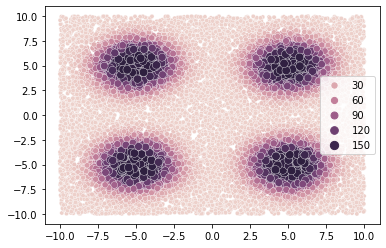

In [168]:
sns.scatterplot(x=torch.cat((test_in, test_out)).numpy()[:,0],y=torch.cat((test_in, test_out)).numpy()[:,1],
                hue = test_in_pred.tolist()+test_out_pred.tolist(), size = test_in_pred.tolist()+test_out_pred.tolist())

# SVDD

In [169]:
from src.svdd_src.svdd import SVDD
from src.svdd_src.visualize import Visualization as draw

In [170]:
train_x = a["train_x"]
train_y = a["train_y"]
test_in = a["test_in"]
test_out = db
parameters = {"positive penalty": 0.9,
              "negative penalty": 0.8,
              "kernel": {"type": 'gauss', "width": 1/24},
              "option": {"display": 'on'}}

svdd = SVDD(parameters)
train_x_list = []
for x in train_x:
    x = x.view(-1).numpy()
    train_x_list.append(x)

train_y_list = [0] * len(train_x_list)

print("fitting to svdd")
train_x = np.array(train_x_list)
train_y = np.array(train_y_list).reshape(-1, 1)
svdd.train(train_x, train_y)

test_in_pred = []
for t_i in test_in:
    t_i = t_i.view(-1).numpy()
    test_in_pred.append(t_i)

test_out_pred = []
for t_o in test_out:
    t_o = t_o.view(-1).numpy()
    test_out_pred.append(t_o)

testData = test_in_pred + test_out_pred
testLabel = [0 for i in range(len(test_in_pred))] + [1 for i in range(len(test_out_pred))]

testData = np.array(testData)
testLabel = np.array(testLabel)
distance, accuracy = svdd.test(testData, testLabel)
print(accuracy)

fitting to svdd


/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


auroc: nan


*** SVDD model training finished ***

iter             = 6
time cost        = 20.7723 s
obj              = -0.0000
pData            = 0.0000 %
nData            = 0.0000 %
nSVs             = 4810
radio of nSVs    = 100.0000 %
accuracy         = 0.0000 %


auroc: 0.8710289320822162


*** SVDD model test finished ***

time cost        = 22.5909 s
accuracy         = 640983.1824 %


6409.831824062096


<AxesSubplot:>

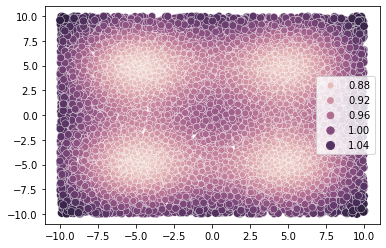

In [171]:
sns.scatterplot(x=testData[:,0],y=testData[:,1],hue=distance,size=distance)

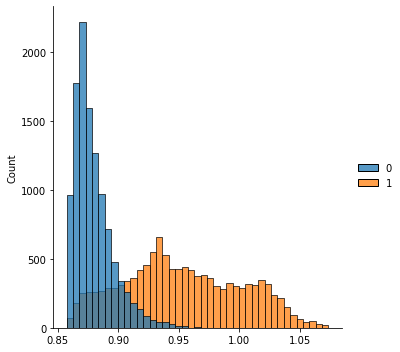

In [185]:
sns.displot(x=distance, hue= testLabel)

end cluster in clad
fc3


/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Calculating NN Classifier training accuracy...
NN Classifier training accuracy : 0.07027027027027027
in-distribution data


/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)


 100/11190 data processed, 1.8 seconds used.
 200/11190 data processed, 0.3 seconds used.
 300/11190 data processed, 0.3 seconds used.
 400/11190 data processed, 0.2 seconds used.
 500/11190 data processed, 0.2 seconds used.
 600/11190 data processed, 0.2 seconds used.
 700/11190 data processed, 0.2 seconds used.
 800/11190 data processed, 0.3 seconds used.
 900/11190 data processed, 0.3 seconds used.
1000/11190 data processed, 0.3 seconds used.
1100/11190 data processed, 0.4 seconds used.
1200/11190 data processed, 0.3 seconds used.
1300/11190 data processed, 0.3 seconds used.
1400/11190 data processed, 0.3 seconds used.
1500/11190 data processed, 0.4 seconds used.
1600/11190 data processed, 0.3 seconds used.
1700/11190 data processed, 0.3 seconds used.
1800/11190 data processed, 0.3 seconds used.
1900/11190 data processed, 0.2 seconds used.
2000/11190 data processed, 0.3 seconds used.
2100/11190 data processed, 0.3 seconds used.
2200/11190 data processed, 0.4 seconds used.
2300/11190

7300/12000 data processed, 0.2 seconds used.
7400/12000 data processed, 0.2 seconds used.
7500/12000 data processed, 0.2 seconds used.
7600/12000 data processed, 0.2 seconds used.
7700/12000 data processed, 0.2 seconds used.
7800/12000 data processed, 0.2 seconds used.
7900/12000 data processed, 0.2 seconds used.
8000/12000 data processed, 0.2 seconds used.
8100/12000 data processed, 0.2 seconds used.
8200/12000 data processed, 0.3 seconds used.
8300/12000 data processed, 0.2 seconds used.
8400/12000 data processed, 0.2 seconds used.
8500/12000 data processed, 0.2 seconds used.
8600/12000 data processed, 0.2 seconds used.
8700/12000 data processed, 0.2 seconds used.
8800/12000 data processed, 0.2 seconds used.
8900/12000 data processed, 0.3 seconds used.
9000/12000 data processed, 0.2 seconds used.
9100/12000 data processed, 0.2 seconds used.
9200/12000 data processed, 0.2 seconds used.
9300/12000 data processed, 0.2 seconds used.
9400/12000 data processed, 0.3 seconds used.
9500/12000

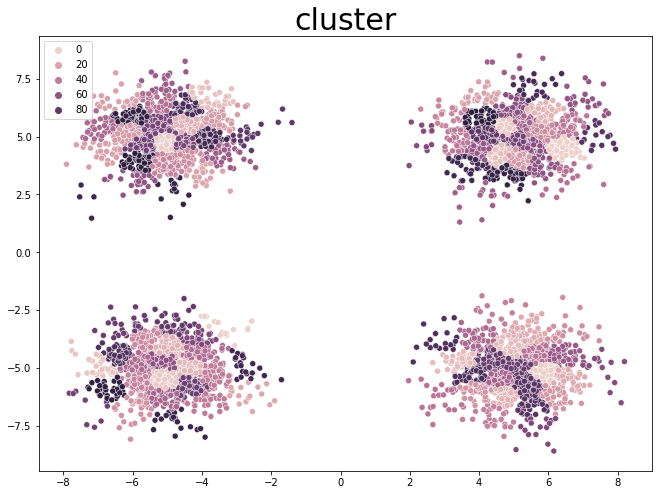

In [13]:
train_x = a["train_x"]
train_y = a["train_y"]
test_in = a["test_in"]
test_out = db
data = data_uncenter
config.device = torch.device("cuda:0")
config.cluster_num = 100
clad = CLAD("toy",train_x, config.cluster_num, "toy", "fc3")
clad.cluster()
config.classifier_epochs = 1
classifier = clad.classify_nn("toy")
#so clad need to return classifier for decision boundary
emb,train,indist,ood = apply_odin(classifier,train_x.float(),test_in.float(),test_out.float(),None,None,None) #db.float()
score_multi,mean_multi,cov_met_multi = get_scores_multi_cluster(train,indist,ood, clad.clusters.numpy())
indist_one, ood_one ,mean_one, cov_met_one = get_scores_one_cluster(train, indist, ood)
emb_ab = emb[emb['label_gt']=='abnormal']
emb_no = emb[emb['label_gt']=='normal']
n = [0 for i in range(len(indist))]
N = [1 for i in range(len(ood))]
n.extend(N)
emb["score_one"] = -np.append(indist_one,ood_one) 
emb["score_multi"] = -np.append(score_multi[0],score_multi[1]) 

In [308]:
fpr, tpr, thresholds = roc_curve(n, emb["score_multi"].tolist(), pos_label=0)
auroc = auc(fpr,tpr)
ix = np.argmax(tpr-fpr)
TH = thresholds[ix]
print(f"multi: {auroc}")

multi: 0.789499761691987


In [309]:
fpr, tpr, thresholds = roc_curve(n, emb["score_one"].tolist(), pos_label=0)
auroc = auc(fpr,tpr)
print(f"multi: {auroc}")

multi: 0.9287379133154603


<AxesSubplot:xlabel='emb_x', ylabel='emb_y'>

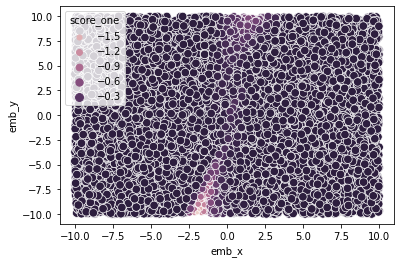

In [242]:
emb = emb.iloc[::-1]
sns.scatterplot(data=emb, x='emb_x',y='emb_y', hue="score_one",size="score_one")

In [301]:
nor = emb[emb["label_gt"] == "normal"]
ab = emb[emb["label_gt"] == "abnormal"]

In [302]:
def func(x,th) :
    if x >= th :
        return "normal"
    else :
        return "abnormal"
emb["pred"] = emb["score_one"].apply(lambda x : func(x,TH))

In [250]:
emb["pred"]

0          normal
1          normal
2          normal
3          normal
4          normal
           ...   
23185    abnormal
23186      normal
23187    abnormal
23188      normal
23189    abnormal
Name: pred, Length: 23190, dtype: object

<AxesSubplot:xlabel='emb_x', ylabel='emb_y'>

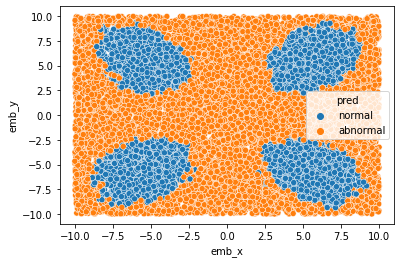

In [303]:
sns.scatterplot(data = emb, x = "emb_x", y = "emb_y", hue = "pred")

In [129]:
score_multi_no,mean_multi_no,cov_met_multi_no = get_scores_multi_cluster(train_x.numpy(),test_in.numpy(),test_out.numpy(), clad.clusters.numpy())
indist_one_no, ood_one_no ,mean_one_no, cov_met_one_no = get_scores_one_cluster(train_x.numpy(),test_in.numpy(),test_out.numpy())

In [130]:
one = -np.append(indist_one_no,ood_one_no) 
multi = -np.append(score_multi_no[0],score_multi_no[1]) 

In [131]:
one.shape,test_in.numpy().shape,test_out.numpy().shape

((23190,), (11190, 2), (12000, 2))

In [132]:
fpr, tpr, thresholds = roc_curve(n, one, pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)

0.5876391048555258


In [133]:
fpr, tpr, thresholds = roc_curve(n, multi, pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)

0.9366622430741733


In [56]:
from sklearn.decomposition import PCA

In [285]:
indist

array([[0.        , 3.8833287 , 0.        , ..., 0.06843698, 7.5522356 ,
        0.        ],
       [0.        , 1.1697767 , 0.11626945, ..., 0.03381815, 0.        ,
        0.        ],
       [0.33017838, 0.        , 0.27080804, ..., 0.        , 0.        ,
        3.3540583 ],
       ...,
       [0.        , 3.9528103 , 0.        , ..., 0.08128959, 7.634655  ,
        0.        ],
       [0.        , 0.8479023 , 0.09512602, ..., 0.        , 0.        ,
        0.0570364 ],
       [0.        , 2.7697685 , 0.        , ..., 0.        , 6.6845236 ,
        0.        ]], dtype=float32)

In [286]:
pca = PCA(n_components=512)
covar_matrix= pca.fit(indist)

In [287]:
covar_matrix.components_

array([[-7.3746690e-03,  4.5026898e-02, -6.1553717e-03, ...,
         9.8319157e-05,  1.1531248e-01, -6.0599454e-02],
       [ 2.5278137e-03, -3.6767900e-02, -5.9875473e-04, ...,
        -1.1907534e-03, -1.3235806e-02,  1.8086212e-02],
       [-9.0600085e-03, -3.9667249e-02, -3.4347177e-03, ...,
         7.8795676e-04, -9.3372673e-02, -6.5679178e-02],
       ...,
       [ 0.0000000e+00, -6.3384009e-06,  1.0793111e-05, ...,
         1.2194505e-06,  8.1514008e-07, -1.7995480e-06],
       [ 0.0000000e+00, -3.5250776e-09,  6.6445298e-09, ...,
         6.7876726e-10,  4.5747583e-10, -9.9475983e-10],
       [-0.0000000e+00, -1.2940272e-04, -5.1533920e-04, ...,
        -3.3233315e-05,  1.3658311e-05,  7.7390112e-05]], dtype=float32)

In [288]:
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([42.3, 81.6, 97.9, 99. , 99.8, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

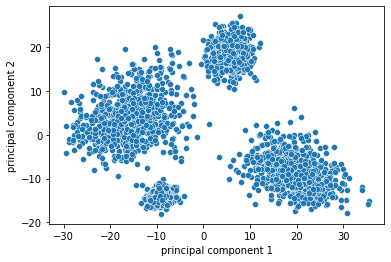

In [289]:
sns.scatterplot(data=principalDf, x='principal component 1',y='principal component 2' )

In [ ]:
cov_met_one_no

In [ ]:
mean_one

In [ ]:
cov_met_one

In [ ]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(x=train[:,0],y=train[:,1])

# 멀리 떨어트리던지 모으는 텀이 필요할 것 같다. 

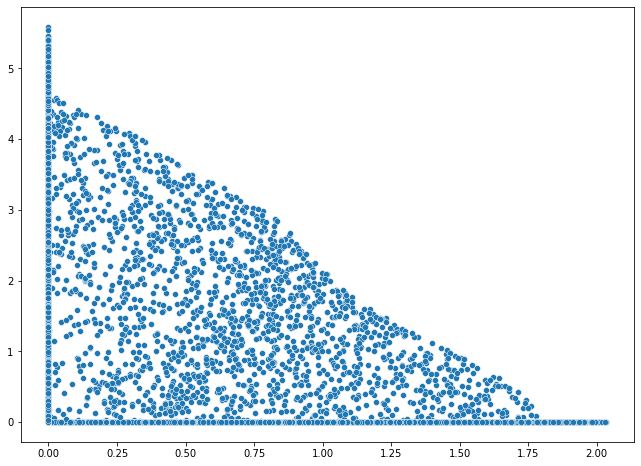

In [21]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(x=ood[:,0],y=ood[:,1])

Text(0.5, 1.0, 'score')

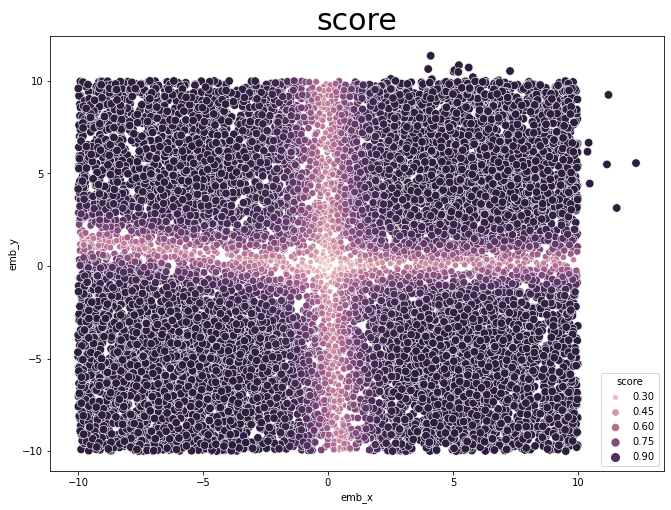

In [22]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data=emb,x="emb_x",y="emb_y", hue="score",size='score')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score",fontsize="30")

In [23]:
TH = calculate_metric()
print(TH)

/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


                 Base         Odin

F1:             44.40%       44.25%
AUROC:          61.68%       61.58%
0.9858609437942505


In [24]:
emb = emb.iloc[::-1]

Text(0.5, 1.0, 'GT normal vs abnormal')

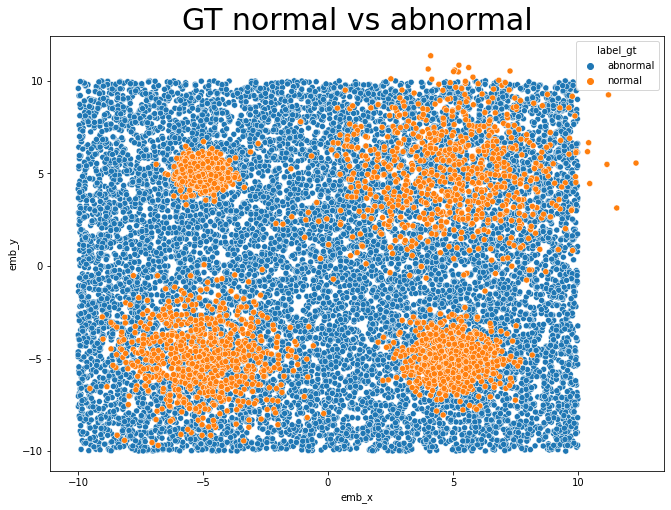

In [25]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data=emb,x="emb_x",y="emb_y", hue="label_gt")
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT normal vs abnormal",fontsize="30")


Text(0.5, 1.0, 'score_mp distribution')

<Figure size 792x792 with 0 Axes>

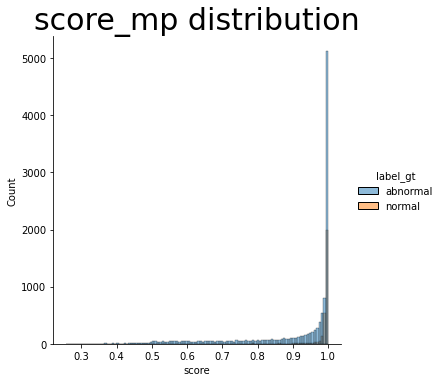

In [26]:
plt.figure(figsize=(11, 11))
fig = sns.displot(emb, x="score", hue="label_gt")
plt.title("score_mp distribution",fontsize="30")

In [ ]:
sns.displot(emb, x="score_one", hue="label_gt")

In [ ]:
plt.figure(figsize=(11, 11))
fig = sns.displot(emb, x="score_multi", hue="label_gt")
plt.title("score_multi distribution",fontsize="30")

In [ ]:
plt.figure(figsize=(11, 11))
fig = sns.displot(emb, x="score_one_no", hue="label_gt")
plt.title("score_one_no distribution",fontsize="30")

In [ ]:
plt.figure(figsize=(11, 11))
fig = sns.displot(emb, x="score_multi_no", hue="label_gt")
plt.title("score_multi_no distribution",fontsize="30")

In [10]:
def get_scores_multi_cluster(ftrain, ftest, food, ypred):
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    means_ = []
    cov = []
    for x in xc:
        means_.append(np.mean(x, axis=0, keepdims=True))
        cov.append(np.cov(x.T, bias=True))
    
    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]

    din = np.min(din, axis=0)
    dood = np.min(dood, axis=0)

    return (din, dood), means_, cov

In [11]:
def get_scores_one_cluster(ftrain, ftest, food, shrunkcov=False):
    if shrunkcov:
        print("Using ledoit-wolf covariance estimator.")
        cov = lambda x: ledoit_wolf(x)[0]
    else:
        cov = lambda x: np.cov(x.T, bias=True)

    # ToDO: Simplify these equations
    dtest = np.sum(
        (ftest - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (ftest - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    dood = np.sum(
        (food - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (food - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    return dtest, dood,np.mean(ftrain, axis=0, keepdims=True),cov(ftrain)

In [30]:
a,b = get_scores_CD(train, indist, ood)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def get_scores_CD(ftrain, ftest, food):
    
    ftrain_avg = np.mean(ftrain, axis=0, keepdims=True)
    din = [1-cosine_similarity(i.reshape(1,-1),ftrain_avg) for i in ftest]
    dood = [1-cosine_similarity(i.reshape(1,-1),ftrain_avg) for i in food] 
    
    return din, dood

In [31]:
c = np.append(a,b)

In [32]:
fpr,tpr,_ = roc_curve(n,c , pos_label=0)
auroc = auc(fpr,tpr)

In [36]:
auroc

0.4265371164730413

In [34]:
def get_scores_UD(ftrain, ftest, food):
    
    ftrain_avg = np.mean(ftrain, axis=0, keepdims=True)
    din = [euclidean_distances(i.reshape(1,-1),ftrain_avg) for i in ftest]
    dood = [euclidean_distances(i.reshape(1,-1),ftrain_avg) for i in food] 
    
    return din, dood

In [35]:
a,b =  get_scores_UD(train, indist, ood)
c = np.append(a,b)
fpr,tpr,_ = roc_curve(n,c , pos_label=0)
auroc = auc(fpr,tpr)

In [123]:
dtest, dood = get_scores_one_cluster(a['train_x'].numpy(),a['test_in'].numpy(),a['test_out'].numpy())

In [134]:
cluster_model = KMeans(n_clusters=1000, random_state = 0).fit(a['train_x'])
nor, ab = get_scores_multi_cluster(a['train_x'].numpy(),a['test_in'].numpy(),a['test_out'].numpy(),cluster_model.labels_)

In [125]:
n = [0 for i in range(len(nor))]
N = [1 for i in range(len(ab))]
n.extend(N)

In [126]:
score_one = np.append(dtest, dood)

In [127]:
score_multi = np.append(nor,ab)
emb_x = np.append(a['test_in'].numpy()[:,0],a['test_out'].numpy()[:,0])
emb_y = np.append(a['test_in'].numpy()[:,1],a['test_out'].numpy()[:,1])

In [128]:
df ={"emb_x": emb_x,"emb_y": emb_y,'score_multi' : -score_multi,'score_one' : -score_one, 'label_gt': n}
df = pd.DataFrame(df)

In [132]:
df["score_multi"]

0        -1.312715
1        -1.363539
2        -0.707505
3        -1.361364
4        -2.291424
           ...    
13995   -40.203643
13996   -48.098558
13997   -34.234832
13998   -51.698442
13999   -36.653112
Name: score_multi, Length: 14000, dtype: float64

In [135]:
fpr, tpr, thresholds = roc_curve(n, -score_multi, pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)
ix = np.argmax(tpr-fpr)
TH = thresholds[ix]

0.9999767840503245


In [86]:
def get_score(v):
    if v > TH:
         score = "normal"
    else:
        score = "abnormal"
    return score

In [87]:
df['label_th'] = df["score_one"].apply(lambda v: get_score(v))

In [88]:
df['label_th']

0        abnormal
1        abnormal
2        abnormal
3        abnormal
4        abnormal
           ...   
13995    abnormal
13996    abnormal
13997    abnormal
13998    abnormal
13999    abnormal
Name: label_th, Length: 14000, dtype: object

In [211]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data=df,x="emb_x",y="emb_y", hue="label_th",size='score_one')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score_one",fontsize="30")

ValueError: Could not interpret value `label_th` for parameter `hue`

<Figure size 792x576 with 0 Axes>

In [107]:
fig = sns.displot(df, x="score_one", hue="label_gt")
plt.title("GT score_one",fontsize="30")

NameError: name 'df' is not defined

In [206]:
dtest, dood = get_scores_one_cluster(a['train_x'].numpy(),a['test_in'].numpy(),a['test_out'].numpy())

In [208]:
n = [0 for i in range(len(dtest))]
N = [1 for i in range(len(dood ))]
n.extend(N)
data = np.append(dtest, dood)
fpr, tpr, thresholds = roc_curve(n, -data, pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)
ix = np.argmax(tpr-fpr)
TH = thresholds[ix]

2.289792296757068e-06


In [209]:
TH

0.9999909415115386

In [194]:
nor, ab = get_scores_one_cluster(a['train_x'].numpy(),a['test_in'].numpy(),db.numpy())

In [199]:
n = [0 for i in range(len(nor))]
N = [1 for i in range(len(ab))]
n.extend(N)

In [185]:
cluster_model = KMeans(n_clusters=1000, random_state = 0).fit(data_center.numpy())
nor, ab = get_scores_multi_cluster(data_center.numpy(),data_center.numpy(),db.numpy(),cluster_model.labels_)

In [186]:
nor.shape

(3000,)

In [187]:
ab.shape

(12000,)

0.5876391048555258


In [201]:
print(TH)

-2.7481225742276347


Text(0.5, 1.0, 'normal_center DB, threshold')

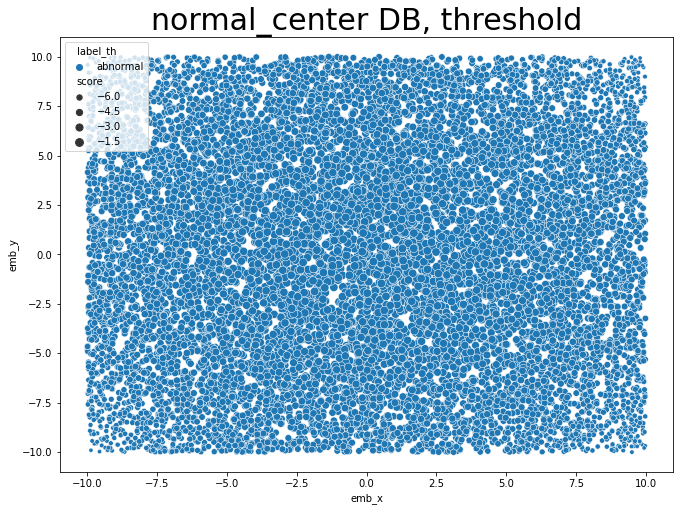

In [210]:
n = [0 for i in range(len(nor))]
N = [1 for i in range(len(ab))]
n.extend(N)
emb_x = np.append(data_center.numpy()[:,0],db[:,0])
emb_y = np.append(data_center.numpy()[:,1],db[:,1])
ma_db ={"emb_x": db[:,0].numpy(),"emb_y": db[:,1].numpy(),'score' : -ab, 'label_gt': N}
ma_db = pd.DataFrame(ma_db)
ma_db['label_th'] = ma_db["score"].apply(lambda v: get_score(v))
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data=ma_db,x="emb_x",y="emb_y", hue="label_th",size='score')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("normal_center DB, threshold",fontsize="30")

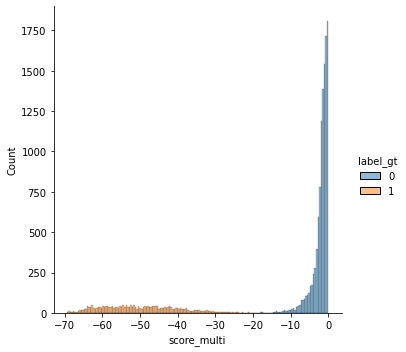

In [105]:
fig = sns.displot(df, x="score_multi", hue="label_gt")
plt.title("GT score_one",fontsize="30")

In [49]:
from transformers import BertModel

In [50]:
BERT = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
outputs=BERT()